In [1]:
# Imports iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler

# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

# Se quiser usar XGBoost / LightGBM
from xgboost import XGBRegressor



In [2]:
df = pd.read_csv("/home/felipe/Projeto/Portfolio/Portfolio2/Regression_PriceHouse/data/processed/complete.csv")

del df['Unnamed: 0']

In [3]:
#criação dos score. Essa etapa será a ultima da EDA. 

df['score_escola_privada'] = (
    1.2 * np.exp(-df['dist_escolas_privadas_mais_proximo'] / 600) +
    0.6 * df['qtd_escolas_privadas_500m']
)

df['score_escola_publica'] = (
    0.6 * np.exp(-df['dist_escola_publicas_mais_proximo'] / 600) +
    0.2 * df['qtd_escola_publicas_500m']
)


df['score_hospitais'] = (
    0.8 * np.exp(-df['dist_hospital_mais_proximo'] / 1200) +
    0.4 * df['qtd_hospital_1000m']
)


df['score_mercado'] = (
    1.0 * np.exp(-df['dist_mercado_mais_proximo'] / 400) +
    0.4 * df['qtd_mercado_500m']
)


df['score_farmacia'] = (
    0.6 * np.exp(-df['dist_farmacia_mais_proximo'] / 300) +
    0.2 * df['qtd_farmacia_300m']
)


df['score_parque'] = (
    1.2 * np.exp(-df['dist_parque_mais_proximo'] / 1200) +
    0.8 * df['qtd_parque_1000m']
)


df['score_seguranca'] = (
    1.0 * np.exp(-df['dist_policia_mais_proximo'] / 1500) +
    0.3 * df['qtd_policia_500m']
)

df['score_educacao'] = (
    df['score_escola_privada']
    - 0.2 * df['score_escola_publica']
)


#Criando a coluna faixa_area
area = df['area_m2']

bins = [0, 50, 80, 120, 200, 400, area.max()]
labels = ['Até 50', '50–80', '80–120', '120–200', '200–400', '400+']

df['faixa_area'] = pd.cut(area, bins=bins, labels=labels)

df['faixa_area'].value_counts(normalize=True).sort_index()

faixa_area
Até 50     0.107443
50–80      0.151954
80–120     0.142557
120–200    0.236029
200–400    0.231083
400+       0.130935
Name: proportion, dtype: float64

In [4]:
def classificar_tipo_imovel(tipo):
    if pd.isna(tipo):
        return "outros"

    tipo = str(tipo).lower()

    if "terreno" in tipo or "lote" in tipo:
        return "terreno"

    if any(x in tipo for x in ["apartamento", "cobertura", "duplex", "flat", "kitnet"]):
        return "apartamento"

    if any(x in tipo for x in ["casa", "sobrado", "vila"]):
        return "casa"

    if any(x in tipo for x in ["comercial", "loja", "box", "galpão", "deposito", "depósito", "sala", "conjunto"]):
        return "comercial"

    if "prédio" in tipo or "edificio" in tipo or "edifício" in tipo:
        return "predio"

    return "outros"


df["tipo_imovel_cat"] = df["tipo_imovel"].apply(classificar_tipo_imovel)

In [5]:
#ajustando o dataframe para valores e formatos corretos. 
pd.options.display.float_format = '{:.4f}'.format

#Filtrando apenas casa, apartamento e sala comerical
df = df[
    df["tipo_imovel_cat"].isin(["casa", "apartamento", "comercial"])
].copy()

#Antes de iniciar, vamos transformar o preço em log
df['log_preco'] = np.log(df['preco'].clip(lower=1))

### DEFINIÇÃO DAS COLUNAS

In [6]:
num_features = [
    'quartos', 'banheiros', 'vagas_garagem', 'area_m2',
    'score_escola_privada', 'score_escola_publica',
    'score_hospitais', 'score_mercado',
    'score_farmacia', 'score_parque', 'score_seguranca'
]

cat_features = ['bairro', 'faixa_area']
target = 'log_preco'


In [7]:
from sklearn.model_selection import train_test_split

X = df[num_features + cat_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


## 🛠️ Criando um Outlier Capper simples (quantis)

### Scikit-learn não tem nativo, então criamos um transformer:

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.q_low_ = X.quantile(self.lower)
        self.q_high_ = X.quantile(self.upper)
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        return X.clip(self.q_low_, self.q_high_, axis=1)


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler


In [10]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', QuantileClipper(0.01, 0.99)),
    ('scaler', StandardScaler())  # depois vamos trocar
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)


In [11]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),

    'RandomForest': RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),

    'GradientBoosting': GradientBoostingRegressor(random_state=42),

    'XGBoost': XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

scalers = {
    'None': None,
    'MaxAbsScaler': MaxAbsScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'Normalizer': Normalizer(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}


In [12]:
results = []

# Depois, no loop, use esta abordagem
for model_name, model in models.items():
    for scaler_name, scaler in scalers.items():
        
        # Criar um novo pipeline numérico com o scaler atual
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('outliers', QuantileClipper(0.01, 0.99)),
            ('scaler', scaler if scaler is not None else 'passthrough')
        ])
        
        # Criar um novo preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', num_pipeline, num_features),
                ('cat', cat_pipeline, cat_features)  # cat_pipeline já definido
            ]
        )
        
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Scaler': scaler_name,
            'R2': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        })


In [13]:
results_df = pd.DataFrame(results)

print(results_df.sort_values(
    by=['R2', 'RMSE'],
    ascending=[False, True]
).reset_index(drop=True))


               Model          Scaler     R2   RMSE    MAE   MAPE
0            XGBoost  StandardScaler 0.8336 0.3362 0.2436 0.0182
1            XGBoost    RobustScaler 0.8330 0.3367 0.2443 0.0183
2            XGBoost            None 0.8312 0.3386 0.2448 0.0183
3            XGBoost    MaxAbsScaler 0.8312 0.3386 0.2448 0.0183
4            XGBoost    MinMaxScaler 0.8312 0.3386 0.2448 0.0183
5       RandomForest    RobustScaler 0.8140 0.3554 0.2519 0.0188
6       RandomForest            None 0.8136 0.3558 0.2520 0.0189
7       RandomForest    MaxAbsScaler 0.8133 0.3561 0.2519 0.0188
8       RandomForest  StandardScaler 0.8133 0.3561 0.2520 0.0189
9       RandomForest    MinMaxScaler 0.8130 0.3564 0.2521 0.0189
10           XGBoost      Normalizer 0.7946 0.3735 0.2698 0.0201
11      RandomForest      Normalizer 0.7911 0.3766 0.2687 0.0201
12  GradientBoosting  StandardScaler 0.7894 0.3781 0.2813 0.0211
13  GradientBoosting    RobustScaler 0.7893 0.3782 0.2822 0.0211
14  GradientBoosting     

## Criando o gráfico de Shap para interpretação do modelo

In [14]:
import shap
import matplotlib.pyplot as plt

# Pipeline numérico final
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', QuantileClipper(0.01, 0.99)),
    ('scaler', StandardScaler())
])

# Pipeline categórico
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Modelo final
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

pipe.fit(X_train, y_train)


/home/felipe/anaconda3/envs/regression/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## 2️⃣ Extrair dados transformados + nomes das features

### ⚠️ Passo crítico: SHAP não entende Pipeline, só o modelo + matriz final.

In [15]:
# Dados transformados
X_train_transformed = pipe.named_steps['preprocessor'].transform(X_train)

# Nomes das features após o OneHot
num_feature_names = num_features

cat_feature_names = (
    pipe.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(cat_features)
)

feature_names = list(num_feature_names) + list(cat_feature_names)


In [16]:
explainer = shap.Explainer(
    pipe.named_steps['model'],
    X_train_transformed,
    feature_names=feature_names
)

shap_values = explainer(X_train_transformed)


 99%|===================| 4995/5064 [00:33<00:00]        

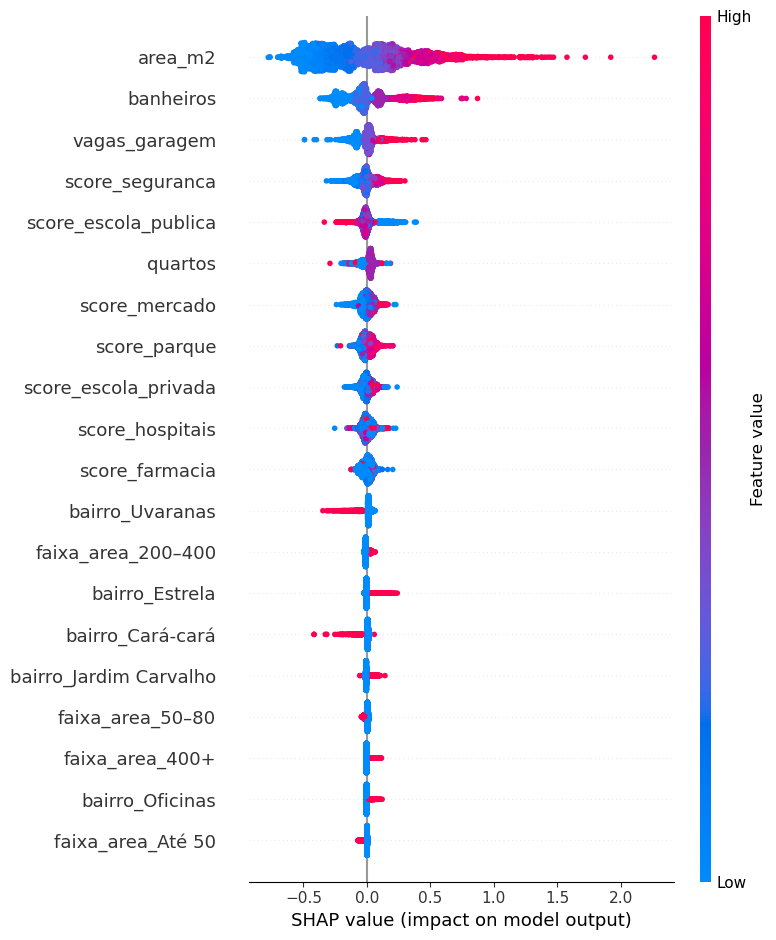

In [17]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    show=True
)


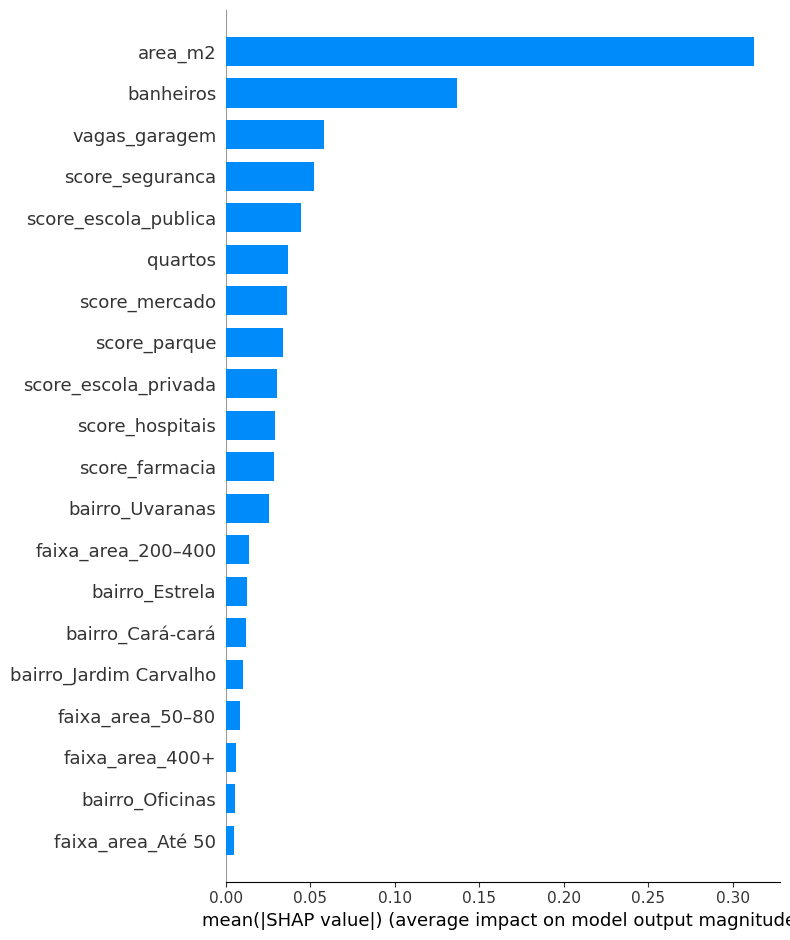

In [18]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)


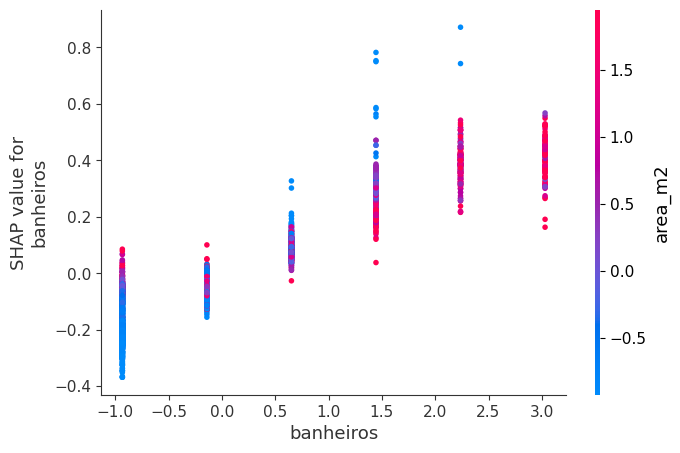

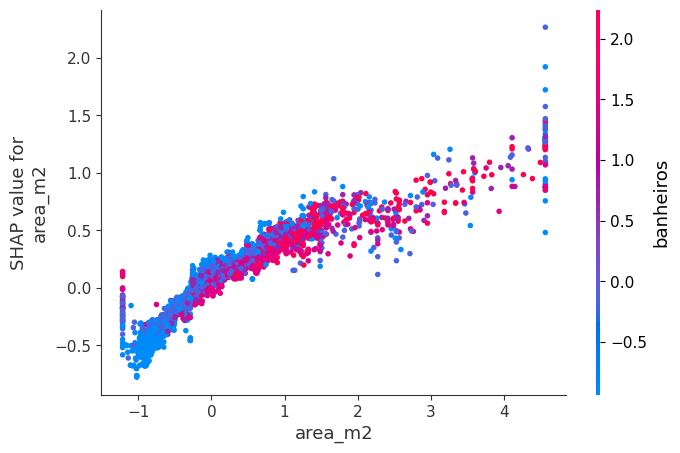

In [19]:
shap.dependence_plot(
    "banheiros",
    shap_values.values,
    X_train_transformed,
    feature_names=feature_names
)

shap.dependence_plot(
    "area_m2",
    shap_values.values,
    X_train_transformed,
    feature_names=feature_names
)


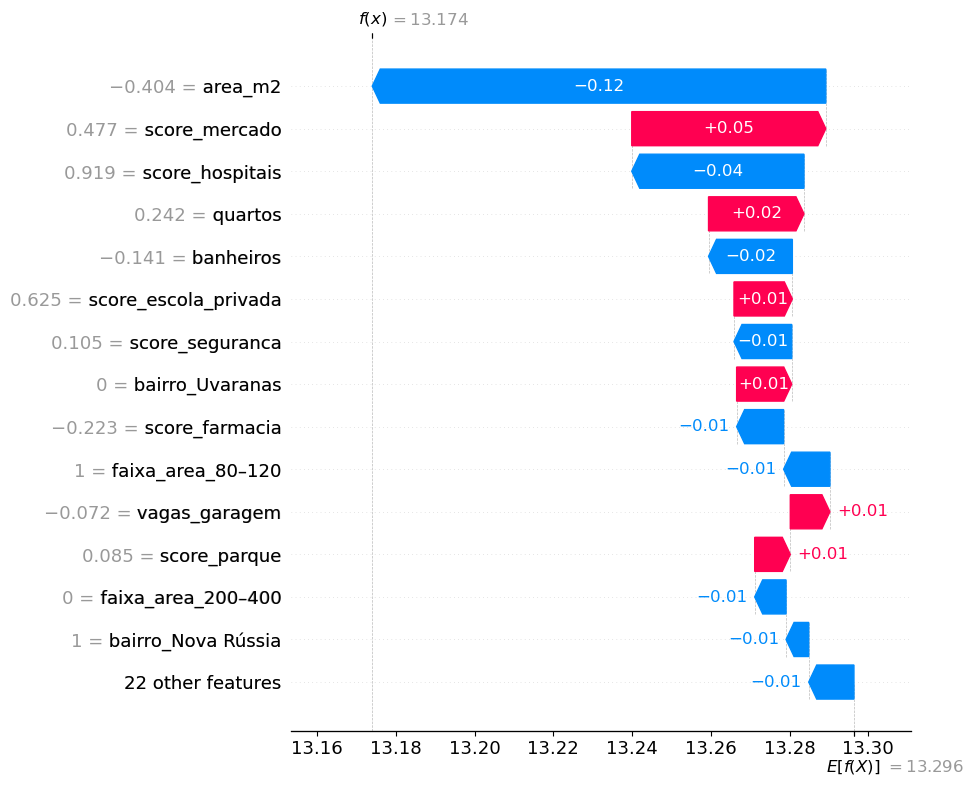

In [20]:
idx = 10  # qualquer índice

shap.plots.waterfall(
    shap_values[idx],
    max_display=15
)


In [21]:
import numpy as np

beta_0 = 13.296
preco_base = np.exp(beta_0)

preco_base

np.float64(594811.6025388334)

# 🧠 Conclusão dos Resultados — SHAP Values

## Interpretação do Modelo via SHAP Values

A análise dos SHAP values foi utilizada para interpretar tanto o comportamento global do modelo quanto previsões individuais, permitindo avaliar a coerência econômica e estatística das variáveis explicativas utilizadas.

### Importância Global das Variáveis

Os resultados indicam que os principais determinantes do preço dos imóveis são variáveis estruturais, com destaque para:

- **Área do imóvel (area_m2)**  
- **Número de banheiros**
- **Número de vagas de garagem**
- **Número de quartos**

Essas variáveis apresentaram os maiores valores absolutos médios de SHAP, indicando que são os principais fatores responsáveis pela variação do preço previsto pelo modelo. O comportamento observado é consistente com a teoria econômica e com a literatura do mercado imobiliário, reforçando a validade do modelo.

### Variáveis de Acessibilidade e Infraestrutura

Variáveis associadas à infraestrutura urbana e serviços, como:

- Score de segurança  
- Score de escolas públicas e privadas  
- Proximidade a mercados, parques e hospitais  

apresentaram impacto relevante, porém secundário. Os SHAP values indicam que melhores condições de acesso e qualidade urbana tendem a aumentar o valor dos imóveis, embora com menor magnitude quando comparadas às características físicas do imóvel.

### Efeito Espacial e Bairros

As variáveis categóricas relacionadas aos bairros, modeladas via One-Hot Encoding, apresentaram impacto individual menor, porém estatisticamente consistente. Esses efeitos capturam heterogeneidades espaciais não totalmente explicadas pelas variáveis estruturais e funcionam como efeitos fixos de localização, refletindo diferenças socioeconômicas, urbanísticas e de infraestrutura entre regiões.

### Interpretação Local das Previsões

A análise local (waterfall plot) demonstra como o modelo parte do valor médio esperado e ajusta a previsão final de acordo com as características específicas de cada imóvel. Observa-se que:
- Valores acima da média em atributos estruturais elevam o preço previsto;
- Valores abaixo da média reduzem o preço, mesmo em imóveis localizados em bairros valorizados.

### Conclusão Geral

Os SHAP values confirmam que o modelo apresenta:
- Coerência econômica;
- Estabilidade interpretativa;
- Transparência na tomada de decisão.

Além disso, os resultados reforçam os achados obtidos nos testes de inferência estatística (ANOVA e regressão), validando o uso do modelo como ferramenta confiável para análise e precificação de imóveis em ambiente produtivo.


## 🔧 Exemplo de Estrutura com Optuna (XGBoost)

In [26]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):

    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 200, 800),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 0.0, 1.0),
        reg_lambda=trial.suggest_float('reg_lambda', 0.0, 1.0),
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse


In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)


[I 2026-02-17 16:33:31,115] A new study created in memory with name: no-name-04d8a64b-8196-4d8c-9038-01422cfda13e
[I 2026-02-17 16:33:31,699] Trial 0 finished with value: 0.3346328203716702 and parameters: {'n_estimators': 643, 'max_depth': 7, 'learning_rate': 0.01944069979778069, 'subsample': 0.8554133166866392, 'colsample_bytree': 0.7813689285348143, 'reg_alpha': 0.06577746784987337, 'reg_lambda': 0.8646887444055444}. Best is trial 0 with value: 0.3346328203716702.
[I 2026-02-17 16:33:31,937] Trial 1 finished with value: 0.33148317770775726 and parameters: {'n_estimators': 364, 'max_depth': 6, 'learning_rate': 0.05742234983610457, 'subsample': 0.8403377378849867, 'colsample_bytree': 0.7759097469500014, 'reg_alpha': 0.14054807214239706, 'reg_lambda': 0.7606542939687945}. Best is trial 1 with value: 0.33148317770775726.
[I 2026-02-17 16:33:33,161] Trial 2 finished with value: 0.34693748856002177 and parameters: {'n_estimators': 560, 'max_depth': 10, 'learning_rate': 0.04506100081219322

[I 2026-02-17 16:33:42,810] Trial 23 finished with value: 0.3421893229200818 and parameters: {'n_estimators': 287, 'max_depth': 10, 'learning_rate': 0.19987163241185554, 'subsample': 0.7893484919634519, 'colsample_bytree': 0.739295457631947, 'reg_alpha': 0.8566544314230659, 'reg_lambda': 0.3575774983524834}. Best is trial 1 with value: 0.33148317770775726.
[I 2026-02-17 16:33:43,605] Trial 24 finished with value: 0.33872561330065415 and parameters: {'n_estimators': 528, 'max_depth': 9, 'learning_rate': 0.038294978669497236, 'subsample': 0.9119524008897538, 'colsample_bytree': 0.8523545463131279, 'reg_alpha': 0.9215718101248348, 'reg_lambda': 0.11161027874082502}. Best is trial 1 with value: 0.33148317770775726.
[I 2026-02-17 16:33:44,054] Trial 25 finished with value: 0.3325463413404377 and parameters: {'n_estimators': 399, 'max_depth': 8, 'learning_rate': 0.02976631356741273, 'subsample': 0.7913644346700034, 'colsample_bytree': 0.7640607001651482, 'reg_alpha': 0.7189006710206589, 'reg

[I 2026-02-17 16:33:53,510] Trial 46 finished with value: 0.3301167871297053 and parameters: {'n_estimators': 502, 'max_depth': 6, 'learning_rate': 0.06716948868668399, 'subsample': 0.9361459872538832, 'colsample_bytree': 0.6486751792551856, 'reg_alpha': 0.5290836736118418, 'reg_lambda': 0.8328871405603294}. Best is trial 35 with value: 0.33005038718531826.
[I 2026-02-17 16:33:53,798] Trial 47 finished with value: 0.3304193803574696 and parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.07734205237688171, 'subsample': 0.8875207530563296, 'colsample_bytree': 0.6851862061248616, 'reg_alpha': 0.48739092087344194, 'reg_lambda': 0.8322164145870088}. Best is trial 35 with value: 0.33005038718531826.
[I 2026-02-17 16:33:54,097] Trial 48 finished with value: 0.33522805638885295 and parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.06655220469348516, 'subsample': 0.8906018235928812, 'colsample_bytree': 0.6462156546586444, 'reg_alpha': 0.49515387684618956, 'r

Best RMSE: 0.33005038718531826
Best params: {'n_estimators': 548, 'max_depth': 7, 'learning_rate': 0.0500329889882667, 'subsample': 0.8835409622658397, 'colsample_bytree': 0.6553919418029063, 'reg_alpha': 0.7897926174933038, 'reg_lambda': 0.7265702614338017}


## ✅ 1. Treinar o modelo final (XGBoost otimizado)

### 🔧 Melhores hiperparâmetros (Optuna)

In [28]:
best_params = {
    'n_estimators': 548,
    'max_depth': 7,
    'learning_rate': 0.0500329889882667,
    'subsample': 0.8835409622658397,
    'colsample_bytree': 0.6553919418029063,
    'reg_alpha': 0.7897926174933038,
    'reg_lambda': 0.7265702614338017,
    'random_state': 42,
    'n_jobs': -1
}

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', QuantileClipper(0.01, 0.99)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

xgb_final = XGBRegressor(**best_params)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_final)
])

final_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## ✅ 2. Avaliação final no holdout

In [29]:
y_pred = final_pipeline.predict(X_test)

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.4%}")


R²   : 0.8396
RMSE : 0.3301
MAE  : 0.2384
MAPE : 1.7837%


### 🔁 Baseline: Regressão Linear (comparação honesta)

In [30]:
from sklearn.linear_model import LinearRegression

baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

baseline_pipeline.fit(X_train, y_train)
y_pred_base = baseline_pipeline.predict(X_test)

print("Baseline Linear Regression")
print(f"R²   : {r2_score(y_test, y_pred_base):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_base)):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred_base):.4f}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred_base):.4%}")


Baseline Linear Regression
R²   : 0.7196
RMSE : 0.4363
MAE  : 0.3284
MAPE : 2.4569%


### ✅ 3. SHAP final (modelo otimizado)

In [31]:
# Transformar os dados
X_train_transformed = final_pipeline.named_steps['preprocessor'].transform(X_train)

feature_names = (
    num_features +
    list(
        final_pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['encoder']
        .get_feature_names_out(cat_features)
    )
)


In [32]:
explainer = shap.Explainer(
    final_pipeline.named_steps['model'],
    X_train_transformed,
    feature_names=feature_names
)

shap_values = explainer(X_train_transformed)


 99%|===================| 5022/5064 [01:39<00:00]        

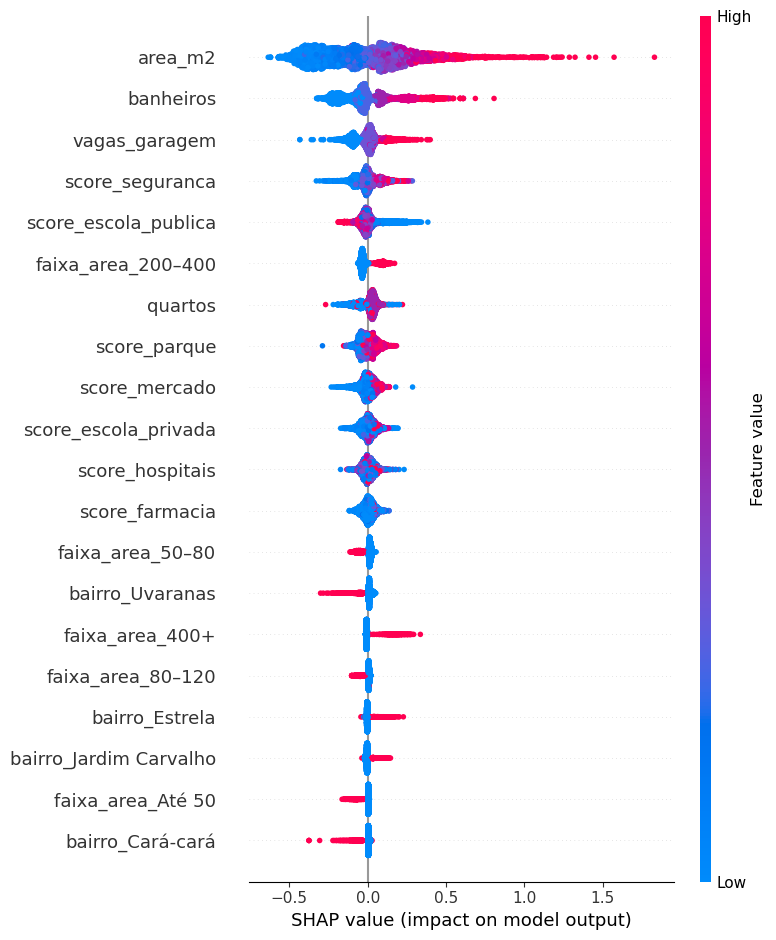

In [33]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)


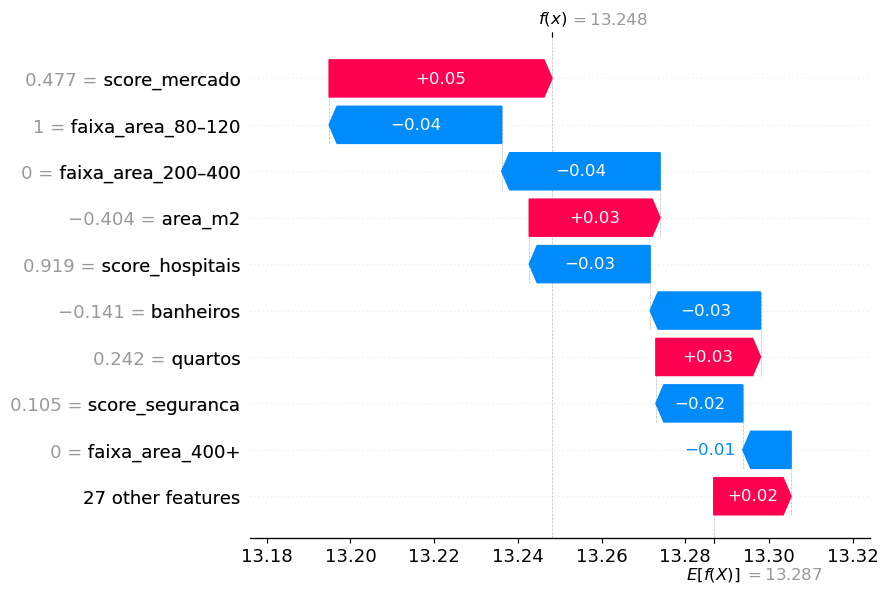

In [35]:
shap.plots.waterfall(shap_values[10])


## 💾 Salvando o modelo (pickle)

In [36]:
import pickle

with open("xgb_price_model.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)


In [37]:
with open("xgb_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

loaded_model.predict(X_test.iloc[:5])


array([14.300361, 12.282964, 12.75527 , 13.420151, 13.164727],
      dtype=float32)